# Ocean Temperatures: Who's hot, who's not?

Objectives: (1) Observe whether temperatures in Pacific and Atlantic Oceans, surrounding the U.S.,
                   are increasing or not. 
            (2) Determine correlations between the two water bodies. 
            (3) Run a Random Forest with average temperatures for Pacific and Arctic to see which is the 
                   best predictor.

In [1]:
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5netcdf


In [2]:
base_url = 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1990-01',end='2020-12', freq='YS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

In [3]:
file_list

['https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1990/e5.moda.an.sfc.128_034_sstk.ll025sc.1990010100_1990120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1991/e5.moda.an.sfc.128_034_sstk.ll025sc.1991010100_1991120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1992/e5.moda.an.sfc.128_034_sstk.ll025sc.1992010100_1992120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1993/e5.moda.an.sfc.128_034_sstk.ll025sc.1993010100_1993120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1994/e5.moda.an.sfc.128_034_sstk.ll025sc.1994010100_1994120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1995/e5.moda.an.sfc.128_034_sstk.ll025sc.1995010100_1995120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1996/e5.moda.an.sfc.128_034_sstk.ll025sc.1996010100_1996120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.

In [4]:
file_list[0]

'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1990/e5.moda.an.sfc.128_034_sstk.ll025sc.1990010100_1990120100.nc'

In [5]:
import fsspec
url = file_list[0]

with fsspec.open(url) as fobj:
    d = xr.open_dataset(fobj)
    print(d)

<xarray.Dataset> Size: 50MB
Dimensions:    (time: 12, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 96B 1990-01-01 1990-02-01 ... 1990-12-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    SSTK       (time, latitude, longitude) float32 50MB ...
    utc_date   (time) int32 48B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:         

In [8]:
ds = xr.open_mfdataset(
    #cached,
    file_list,
    engine= 'h5netcdf',         # or "h5netcdf"
    combine="by_coords",
    chunks={"time": 12},      # modest time chunks
    parallel=False,           # <- important: don't delay opens
    #backend_kwargs={"storage_options": {"simplecache": {"cache_storage": "./_gdex_cache"}}},
)

ClientResponseError: 504, message='Gateway Timeout', url='https://pelican-cache.rc.duke.edu/ncar/gdex/d633001/e5.moda.an.sfc/1992/e5.moda.an.sfc.128_034_sstk.ll025sc.1992010100_1992120100.nc'

In [ ]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 372, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    SSTK       (time, latitude, longitude) float32 2GB dask.array<chunksize=(12, 389, 776), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

Create three separate zones for analysis: Atlantic, Pacific, Arctic

In [ ]:
ds_atlantic = ds.sel(latitude = slice(50,20), longitude = slice(270,330))
ds_atlantic

<xarray.Dataset> Size: 43MB
Dimensions:    (time: 372, latitude: 121, longitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 270.0 270.2 270.5 ... 329.5 329.8 330.0
Data variables:
    SSTK       (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 241), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

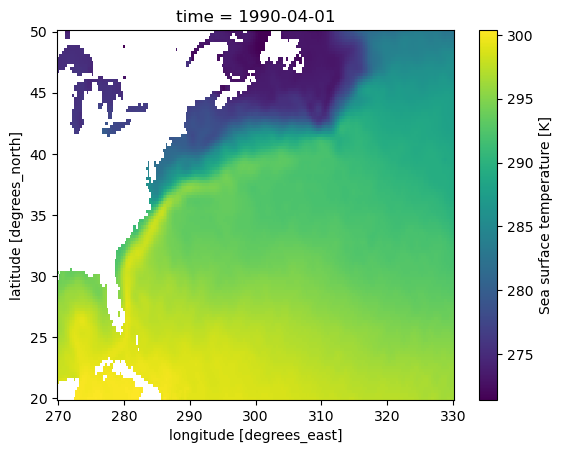

In [ ]:
ds_atlantic['SSTK'][3,:,:].plot()

In [ ]:
ds_pacific = ds.sel(latitude = slice(50,20), longitude = slice(185,245))
ds_pacific

<xarray.Dataset> Size: 43MB
Dimensions:    (time: 372, latitude: 121, longitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 185.0 185.2 185.5 ... 244.5 244.8 245.0
Data variables:
    SSTK       (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 36), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

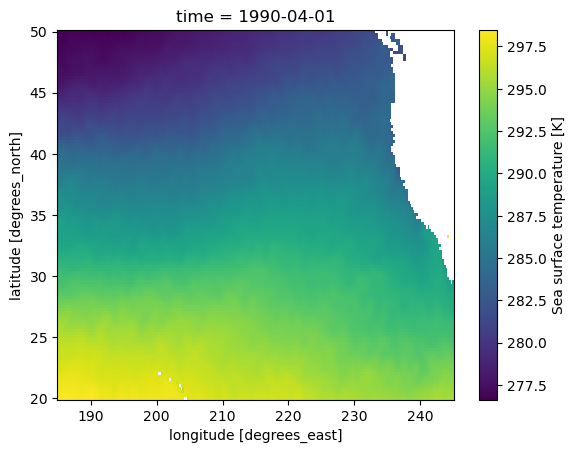

In [ ]:
ds_pacific['SSTK'][3,:,:].plot()

In [ ]:
ds_arctic = ds.sel(latitude = slice(90,60), longitude = slice(180,330))
ds_arctic

<xarray.Dataset> Size: 108MB
Dimensions:    (time: 372, latitude: 121, longitude: 601)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 90.0 89.75 89.5 89.25 ... 60.5 60.25 60.0
  * longitude  (longitude) float64 5kB 180.0 180.2 180.5 ... 329.5 329.8 330.0
Data variables:
    SSTK       (time, latitude, longitude) float32 108MB dask.array<chunksize=(12, 121, 56), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

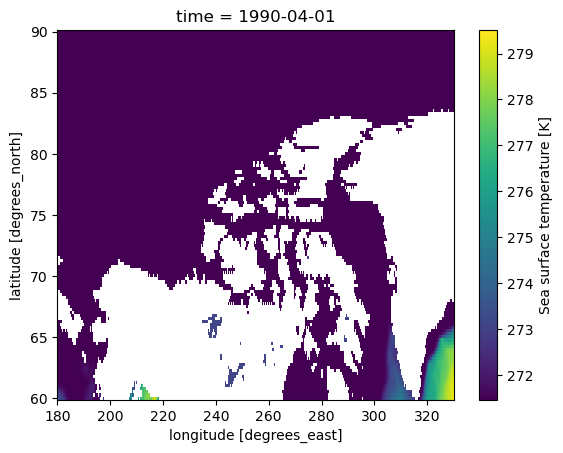

In [ ]:
ds_arctic['SSTK'][3,:,:].plot()

Add Anomalies to our dataset

Starting with the Atlantic Zone

In [ ]:
mean_atl = ds_atlantic.mean(dim=['latitude','longitude'])
mean_atl

<xarray.Dataset> Size: 6kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK      (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    utc_date  (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

In [ ]:
anom_atl = ds_atlantic - mean_atl
anom_atl = anom_atl.rename_vars({'SSTK':'anom'})
anom_atl

<xarray.Dataset> Size: 43MB
Dimensions:    (latitude: 121, longitude: 241, time: 372)
Coordinates:
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 270.0 270.2 270.5 ... 329.5 329.8 330.0
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    anom       (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 241), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

In [ ]:
ds_at = ds_atlantic.copy()
ds_at

<xarray.Dataset> Size: 43MB
Dimensions:    (time: 372, latitude: 121, longitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 270.0 270.2 270.5 ... 329.5 329.8 330.0
Data variables:
    SSTK       (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 241), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

In [ ]:
dss_atlantic = xr.combine_by_coords([ds_at,anom_atl], compat = 'override')
dss_atlantic = dss_atlantic.rename({'SSTK':'SSTK_atl', 'anom':'anom_atl'})
dss_atlantic

<xarray.Dataset> Size: 87MB
Dimensions:    (time: 372, latitude: 121, longitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 270.0 270.2 270.5 ... 329.5 329.8 330.0
Data variables:
    SSTK_atl   (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 241), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_atl   (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 241), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

Pacific Zone

In [ ]:
mean_pac = ds_pacific.mean(dim=['latitude','longitude'])

In [ ]:
anom_pac = ds_pacific - mean_pac
anom_pac = anom_pac.rename_vars({'SSTK':'anom'})

In [ ]:
ds_pcf = ds_pacific.copy()

In [ ]:
dss_pacific = xr.combine_by_coords([ds_pcf,anom_pac], compat = 'override')
dss_pacific = dss_pacific.rename({'SSTK':'SSTK_pac','anom':'anom_pac'})
dss_pacific

<xarray.Dataset> Size: 87MB
Dimensions:    (time: 372, latitude: 121, longitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 2kB 185.0 185.2 185.5 ... 244.5 244.8 245.0
Data variables:
    SSTK_pac   (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 36), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_pac   (time, latitude, longitude) float32 43MB dask.array<chunksize=(12, 121, 36), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

Arctic

In [ ]:
mean_arc = ds_arctic.mean(dim=['latitude','longitude'])

In [ ]:
anom_arc = ds_arctic - mean_arc
anom_arc = anom_arc.rename_vars({'SSTK':'anom'})

In [ ]:
ds_arc = ds_pacific.copy()

In [ ]:
dss_arctic = xr.combine_by_coords([ds_arc,anom_arc], compat = 'override')
dss_arctic = dss_arctic.rename({'SSTK':'SSTK_arc', 'anom':'anom_arc'})
dss_arctic

/tmp/ipykernel_1280/1787970208.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  dss_arctic = xr.combine_by_coords([ds_arc,anom_arc], compat = 'override')
/tmp/ipykernel_1280/1787970208.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  dss_arctic = xr.combine_by_coords([ds_arc,anom_arc], compat = 'override')


<xarray.Dataset> Size: 433MB
Dimensions:    (latitude: 242, longitude: 601, time: 372)
Coordinates:
  * latitude   (latitude) float64 2kB 20.0 20.25 20.5 20.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 5kB 180.0 180.2 180.5 ... 329.5 329.8 330.0
  * time       (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_arc   (time, latitude, longitude) float32 216MB dask.array<chunksize=(12, 121, 120), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_arc   (time, latitude, longitude) float32 216MB dask.array<chunksize=(12, 121, 56), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:39:18 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:39:19 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

Make Averages for a more simple analysis

In [ ]:
avgs_atlantic = dss_atlantic.mean(dim = ['latitude', 'longitude'])
avgs_atlantic

<xarray.Dataset> Size: 7kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    utc_date  (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

In [ ]:
avgs_pacific = dss_pacific.mean(dim = ['latitude', 'longitude'])
avgs_pacific

<xarray.Dataset> Size: 7kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    utc_date  (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

In [ ]:
avgs_arctic = dss_arctic.mean(dim = ['latitude', 'longitude'])
avgs_arctic

<xarray.Dataset> Size: 7kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    utc_date  (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

Merge datasets

In [ ]:
ds_combined = xr.combine_by_coords([avgs_atlantic,avgs_pacific, avgs_arctic], compat='override')
ds_combined

<xarray.Dataset> Size: 13kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    utc_date  (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

In [ ]:
ds_combined = ds_combined.drop_vars('utc_date')
ds_combined.to_netcdf('final_ds')

ds_zones = xr.open_dataset('final_ds')
ds_zones

<xarray.Dataset> Size: 12kB
Dimensions:   (time: 372)
Coordinates:
  * time      (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
Data variables:
    SSTK_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_atl  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_pac  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
    anom_arc  (time) float32 1kB dask.array<chunksize=(12,), meta=np.ndarray>

Temperature Over time

In [ ]:
ds_zones['SSTK_atl'].plot()
ds_zones['SSTK_pac'].plot()
plt.legend(['Atlantic','Pacific'])
plt.title('Average Sea Surface Temps')
plt.show()

ClientPayloadError: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>

In [ ]:
rolled_atl = ds_zones['SSTK_atl'].rolling(time=12, center = True).mean()
rolled_pac = ds_zones['SSTK_pac'].rolling(time=12, center = True).mean()

ClientResponseError: 504, message='Gateway Timeout', url='https://pelican-cache.rc.duke.edu/ncar/gdex/d633001/e5.moda.an.sfc/2002/e5.moda.an.sfc.128_034_sstk.ll025sc.2002010100_2002120100.nc'

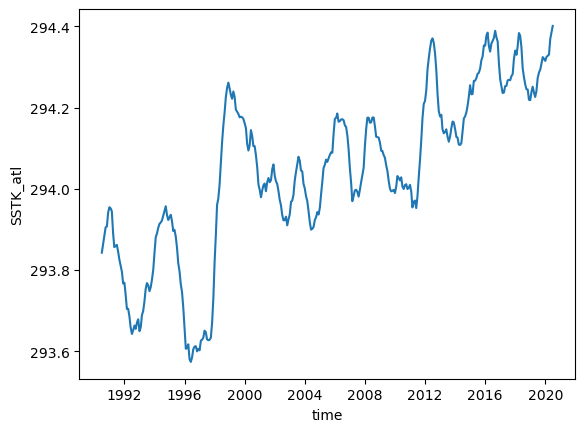

In [ ]:
rolled_atl.plot()
rolled_pac.plot()
plt.legend(['Atlantic', 'Pacific'])
plt.show()

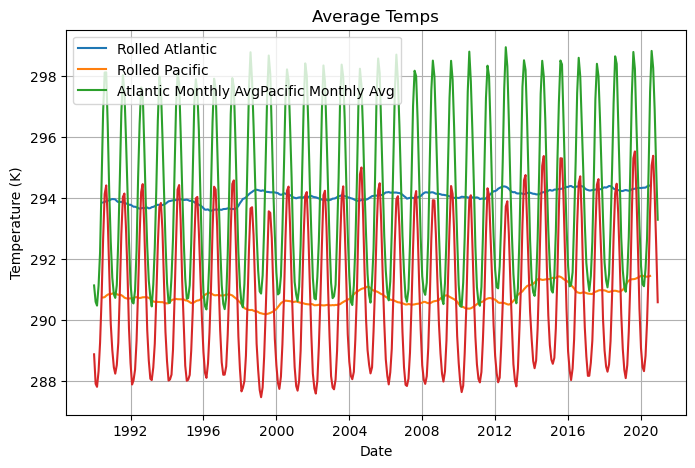

In [ ]:
plt.figure(figsize=(8, 5))
Rolling_Atlantic = rolled_atl.plot()
Rolling_Pacific = rolled_pac.plot()
Atlantic_Avg = ds_zones['SSTK_atl'].plot()
Pacific_Avg = ds_zones['SSTK_pac'].plot()
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.title("Average Temps")
plt.legend(['Rolled Atlantic','Rolled Pacific', 'Atlantic Monthly Avg', 'Pacific Monthly Avg'])
plt.grid(True)
plt.show()


Linear Regression for temperature between Atlantic and Pacific

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = ds_zones['SSTK_atl'].values
Y = ds_zones['SSTK_pac'].values

X = X.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=0,train_size = 0.7)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

ClientResponseError: 504, message='Gateway Timeout', url='https://pelican-cache.rc.duke.edu/ncar/gdex/d633001/e5.moda.an.sfc/1995/e5.moda.an.sfc.128_034_sstk.ll025sc.1995010100_1995120100.nc'

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
Rsqrd = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 = {Rsqrd}" )

Mean Squared Error: 0.3236141800880432
Mean Absolute Error: 0.42515891790390015
R^2 = 0.9397867918014526


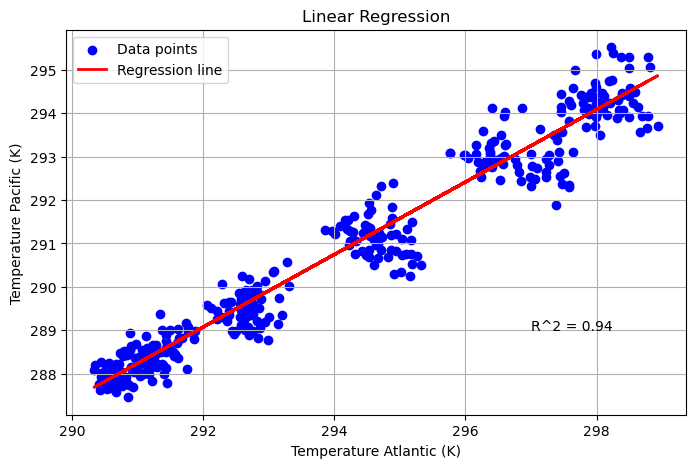

In [ ]:
# Plot scatter points and regression line
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, color='blue', label='Data points')
plt.plot(x_test, predictions, color='red', linewidth=2, label='Regression line')
plt.xlabel("Temperature Atlantic (K)")
plt.ylabel("Temperature Pacific (K)")
plt.title("Linear Regression")
plt.text(297,289,"R^2 = 0.94")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
train_data = X

def KMeansModel(n):
    pca = PCA(n_components=2)
    reduced_train_data = pca.fit_transform(train_data)
    KM = KMeans(n_clusters=n)
    KM.fit(reduced_train_data)
    plt.plot(reduced_train_data[:, 0], reduced_train_data[:, 1], 'k.', markersize=2)
    centroids = KM.cluster_centers_

    for ind,i in enumerate(centroids):
        class_inds=np.where(KM.labels_==ind)[0]
        max_dist=np.max(metrics.pairwise_distances(i, reduced_train_data[class_inds]))
        print(max_dist)
        plt.gca().add_artist(plt.Circle(i, max_dist, fill=False))
    plt.show()

Random Forest Regression

In [41]:
# Create Panda DataFrame
panda_df = {
    'SSTK_atl': ds_zones['SSTK_atl'].values,
    'SSTK_pac': ds_zones['SSTK_pac'].values,
    'SSTK_arc': ds_zones['SSTK_arc'].values,
    'anom_atl': ds_zones['anom_atl'].values,
    'anom_pac': ds_zones['anom_pac'].values,
    'anom_arc': ds_zones['anom_arc'].values,
    'time': ds_zones.time.values
}


df = pd.DataFrame(panda_df)
pd.to_datetime(df['time'])
df.set_index('time', inplace = True)

df



,SSTK_atl,SSTK_pac,SSTK_arc,anom_atl,anom_pac,anom_arc
time,,,,,,
1990-01-01,291.123505,288.865845,288.865845,0.000001,-0.000016,0.000016
1990-02-01,290.585175,287.898926,287.898926,0.000002,0.000007,-0.000010
1990-03-01,290.462036,287.800079,287.800049,0.000002,-0.000023,0.000013
1990-04-01,291.116180,288.313660,288.313629,0.000016,-0.000011,-0.000012
1990-05-01,292.209595,289.249298,289.249298,0.000013,-0.000007,-0.000003
...,...,...,...,...,...,...
2020-08-01,298.810974,295.056671,295.056702,-0.000010,0.000018,0.000021
2020-09-01,298.251923,295.373352,295.373352,-0.000008,0.000007,0.000015
2020-10-01,296.869263,294.116852,294.116852,0.000016,-0.000008,0.000034


In [42]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop('SSTK_atl', axis=1)
y = df['SSTK_atl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# create model
model_randForest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=1)

# fit model
model_randForest.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Mean Squared Error: 0.546
R^2 = 0.92608048577382


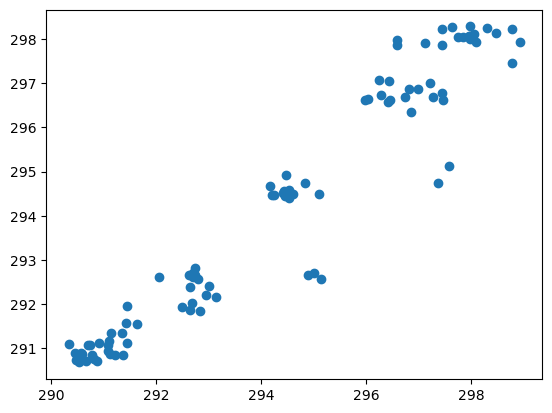

In [43]:
yhat = model_randForest.predict(X_test)
plt.scatter(y_test, yhat)

# Report the correlation coefficient and RMSE of your model.

mse_forest = mean_squared_error(y_test, yhat)
print('Mean Squared Error: %.3f' % mse_forest)

Rsqrd = r2_score(y_test, yhat)
print(f"R^2 = {Rsqrd}" )

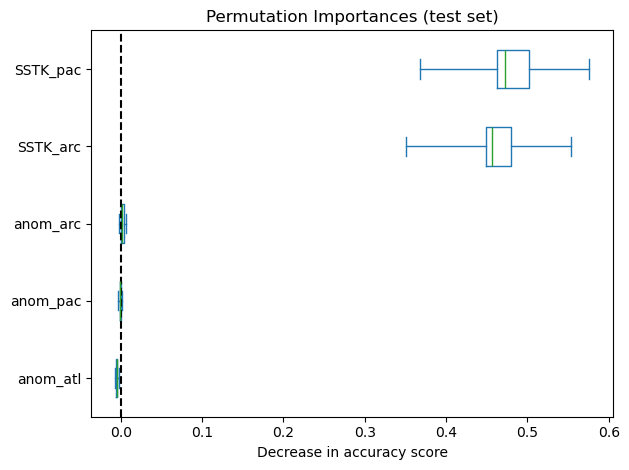

In [44]:
# Perform a feature importance and multipass permutation analysis of your features.
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_randForest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()